In [ ]:
# 참고 : https://www.kaggle.com/shantanubiswas/u-net-lung-segmentation-montgomery-shenzhen

In [1]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"briansong","key":"71f31d87b0102c0edd1ef4d964c91897"}'}

In [3]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [4]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# 7.Kaggle 에서 chest-xray dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
# dataset URL : https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities

# dataset URL : https://www.kaggle.com/yoctoman/shcxr-lung-mask
!kaggle datasets download -d yoctoman/shcxr-lung-mask

Dataset URL: https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities
License(s): unknown
100% 4.08G/4.09G [02:52<00:00, 31.9MB/s]
100% 4.09G/4.09G [02:52<00:00, 25.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/yoctoman/shcxr-lung-mask
License(s): CC-BY-NC-SA-4.0
 86% 17.0M/19.8M [00:01<00:00, 19.0MB/s]
100% 19.8M/19.8M [00:01<00:00, 15.8MB/s]


In [6]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('pulmonary-chest-xray-abnormalities.zip') as y:
    y.extractall()

with ZipFile('shcxr-lung-mask.zip') as z:
    z.extractall()

In [7]:
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input

mkdir: cannot create directory ‘/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input’: File exists


In [8]:
# dataset을 내 구글 드라이버로 이동시킴
!cp -r ChinaSet_AllFiles /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input
!cp -r Montgomery /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input
!cp -r mask /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input

^C
^C
^C


In [ ]:
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/test
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/train
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/train/augmentation
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/train/image
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/train/mask
!mkdir  /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/train/dilate

In [ ]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [ ]:
INPUT_DIR = os.path.join("/content/gdrive/My Drive/CV/X-ray_lung_segmentation", "input")

SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")
SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")

SHENZHEN_TRAIN_DIR = os.path.join(INPUT_DIR, "ChinaSet_AllFiles", "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(INPUT_DIR, "mask", "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(INPUT_DIR, "Montgomery", "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "ManualMask", "rightMask")

DILATE_KERNEL = np.ones((15, 15), np.uint8)

BATCH_SIZE=2

#Prod
EPOCHS=56

In [ ]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))   # Montgomery left lung mask 이미지 경로에 있는 모든 이미지를 가져온다.
montgomery_test = montgomery_left_mask_dir[0:50]    # 가져온 전체 left lung mask 이미지 중 50장은 Test Dataset
montgomery_train = montgomery_left_mask_dir[50:]     # 나머지는 Train Dataset

for left_image_file in tqdm(montgomery_left_mask_dir):           # left lung mask 전체
    base_file = os.path.basename(left_image_file)                # 전체 경로에서 파일이름만 가져옴
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)   # left lung mask와 짝을 이루는(파일 이름이 같은) chest x-ray 이미지를 정의
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)  # left lung mask와 짝을 이루는(파일 이름이 같은) right lung mask 이미지를 정의

    image = cv2.imread(image_file)  # chest x-ray 이미지 읽어옴
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)  # left lung mask 를 gray로 읽어옴
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)  # right lung mask 를 gray로 읽어옴

    # image resizing
    image = cv2.resize(image, (512, 512))
    left_mask = cv2.resize(left_mask, (512, 512))
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)  # left lung mask 와 right lung mask 를 합친다.
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), image)   # Training Dataset에 chest x-ray 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), mask)     # Training Dataset에 mask 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), mask_dilate) # Training Dataset에 mask 이미지를 writing
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), image)   # Test Dataset에 chest x-ray 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)  # Test Dataset에 mask 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)  # Test Dataset에 delate 이미지를 writing

100%|██████████| 138/138 [04:54<00:00,  2.14s/it]


In [ ]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)

    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

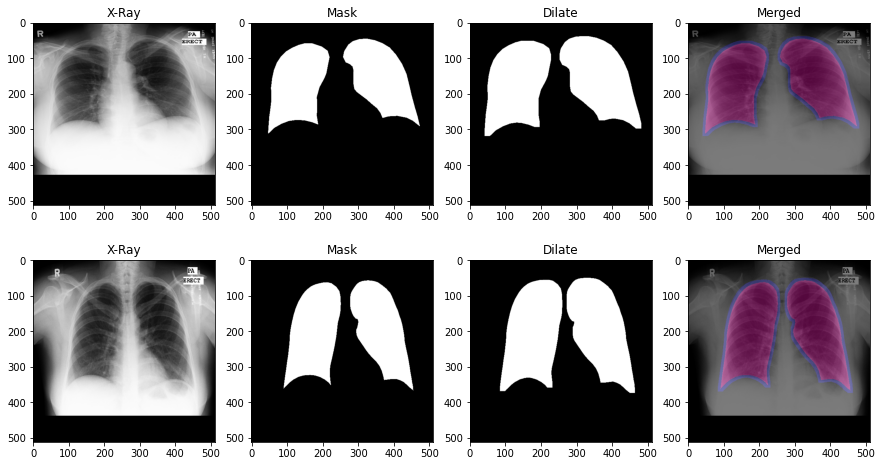

In [ ]:
base_file = os.path.basename(montgomery_train[0])    # montgomery Training Dataset의 첫번째 파일 이름을 가져옵니다.

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)          # 첫번째 파일의 chest x-ray 이미지 정의
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)      # 첫번째 파일의 mask 이미지 정의
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)  # 첫번째 파일의 dilate 이미지 정의

image = cv2.imread(image_file)             # 첫번째 파일의 chest x-ray 이미지를 읽어 옵니다.
mask_image = cv2.imread(mask_image_file)   # 첫번째 파일의 mask 이미지 이미지를 읽어 옵니다.
dilate_image = cv2.imread(dilate_image_file)  # 첫번째 파일의 dilate 이미지를 읽어 옵니다.
merged_image = add_colored_dilate(image, mask_image, dilate_image)  # chest x-ray + mask + dilate 이미지를 merge 합니다.

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# Training DataSet 샘플 출력
axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)


base_file = os.path.basename(montgomery_test[0])    # montgomery Test Dataset의 첫번째 파일 이름을 가져옵니다.
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)   # 첫번째 파일의 chest x-ray 이미지 정의
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext))     # 첫번째 파일의 mask 이미지 정의
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext)) # 첫번째 파일의 dilate 이미지 정의

image = cv2.imread(image_file)   # 첫번째 파일의 chest x-ray 이미지를 읽어옵니다.
mask_image = cv2.imread(mask_image_file)     # 첫번째 파일의 mask 이미지 이미지를 읽어 옵니다.
dilate_image = cv2.imread(dilate_image_file) # 첫번째 파일의 dilate 이미지를 읽어 옵니다.
merged_image = add_colored_dilate(image, mask_image, dilate_image)  # chest x-ray + mask + dilate 이미지를 merge 합니다.

# Test DataSet 샘플 출력
axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
print(len(montgomery_train))
print(len(montgomery_test))

88
50


In [ ]:
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))    # shenzhen mask 이미지 경로에 있는 모든 이미지를 가져온다.
shenzhen_test = shenzhen_mask_dir[0:50]  # 가져온 전체 mask 이미지 중 50장은 Test Dataset
shenzhen_train= shenzhen_mask_dir[50:]   # 나머지는 Training Dataset

for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)  # mask 이미지 파일 정의

    image = cv2.imread(image_file)                      # mask 이미지를 읽어옵니다.
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)  # mask 이미지를 gray 로 변환합니다.

    # image resizing
    image = cv2.resize(image, (512, 512))
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)  # mask 이미지를 확장

    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), image)  # Training Dataset에 chest x-ray 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), mask)    # Training Dataset에 mask 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), mask_dilate)  # Training Dataset에 dilate 이미지를 writing
    else:
        filename, fileext = os.path.splitext(base_file)

        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), image)   # Training Dataset에 chest x-ray 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)  # Training Dataset에 mask 이미지를 writing
        cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate) # Training Dataset에 dilate 이미지를 writing

100%|██████████| 566/566 [02:08<00:00,  4.42it/s]


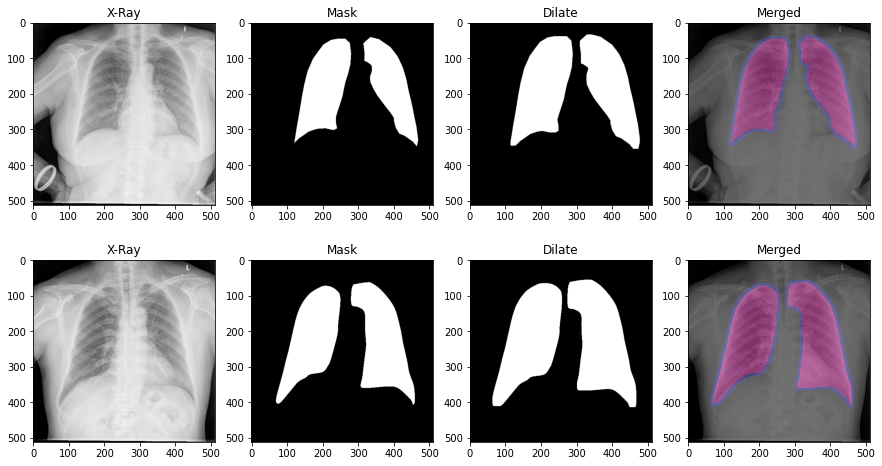

In [ ]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))    # shenzhen Training Dataset의 첫번째 파일 이름을 가져옵니다.

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)         # 첫번째 파일의 chest x-ray 이미지 정의
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)     # 첫번째 파일의 mask 이미지 정의
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file) # 첫번째 파일의 dilate 이미지 정의

image = cv2.imread(image_file)               # 첫번째 파일의 chest x-ray 이미지를 불러옵니다
mask_image = cv2.imread(mask_image_file)     # 첫번째 파일의 mask 이미지를 불러옵니다
dilate_image = cv2.imread(dilate_image_file) # 첫번째 파일의 dilate 이미지를 불러옵니다.
merged_image = add_colored_dilate(image, mask_image, dilate_image)  # chest x-ray + mask + dilate 이미지를 merge 합니다.

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# Training DataSet 샘플 출력
axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))   # shenzhen Test Dataset의 첫번째 파일 이름을 가져옵니다
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)    # 첫번째 파일의 chest x-ray 이미지 정의
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_mask%s" % (filename, fileext))  # 첫번째 파일의 mask 이미지 정의
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, "%s_dilate%s" % (filename, fileext)) # 첫번째 파일의 dilate 이미지 정의

image = cv2.imread(image_file)            # 첫번째 파일의 chest x-ray 이미지를 불러옵니다
mask_image = cv2.imread(mask_image_file)  # 첫번째 파일의 mask 이미지를 불러옵니다
dilate_image = cv2.imread(dilate_image_file) # 첫번째 파일의 dilate 이미지를 불러옵니다
merged_image = add_colored_dilate(image, mask_image, dilate_image)  # chest x-ray + mask + dilate 를 merge 합니다.

# Test DataSet 샘플 출력
axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

In [ ]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

# Training Dataset, Test Dataset, Mask Dataset, Dilate Dataset
(len(train_files), len(test_files), len(mask_files), len(dilate_files))

(604, 300, 604, 604)

In [ ]:
# Segmentation Training

def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [ ]:
# U-Net Architecture

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

In [ ]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(512,512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))

model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

model_checkpoint = ModelCheckpoint('unet_lung_seg.hdf5',
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=[model_checkpoint],
                              validation_data = validation_data)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

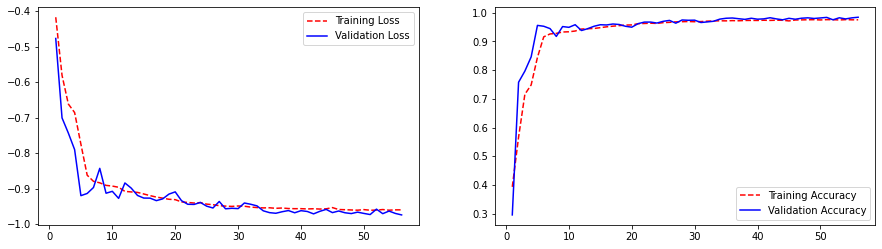

In [ ]:
# 모델 학습 결과를 그래프로 확인합니다.

fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [ ]:
# Test Dataset(100 개)로 lung segmentation 예측 실행

test_gen = test_generator(test_files, target_size=(512,512))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

Instructions for updating:
Please use Model.predict, which supports generators.
100/100 [==============================] - 5s 55ms/step


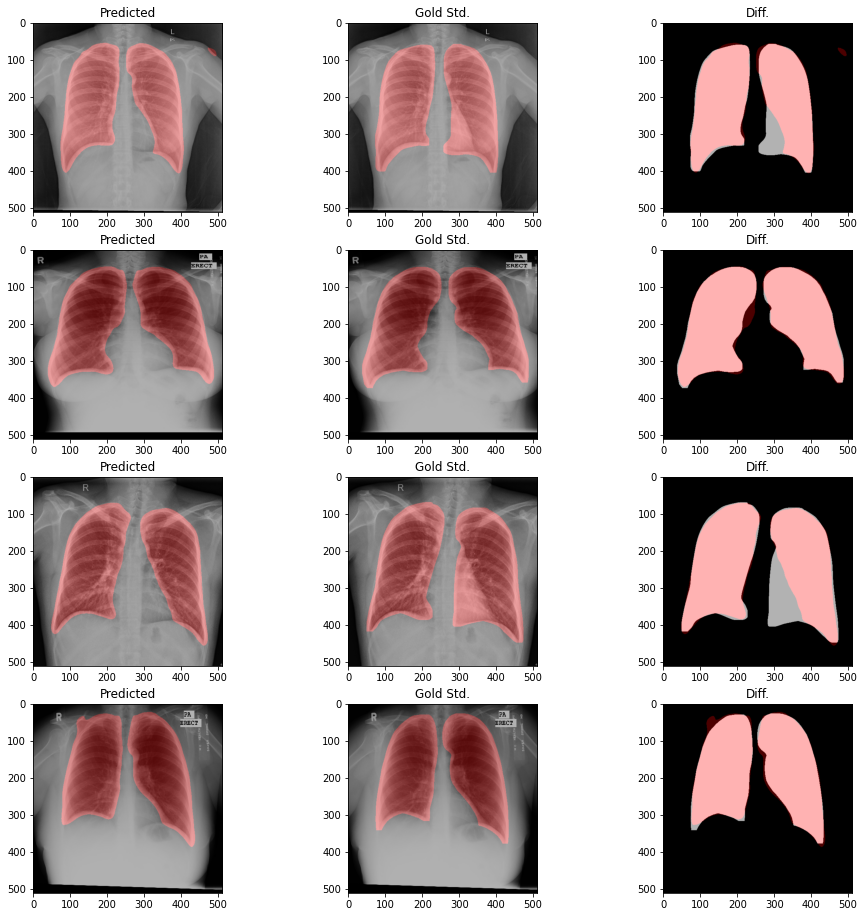

In [ ]:
# 예측결과 중 4개만 Display

image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0003_0.png")
predict_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0003_0_dilate.png")

fig, axs = plt.subplots(4, 3, figsize=(16, 16))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0003_0.png")
predict_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0003_0_dilate.png")

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0020_0.png")
predict_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0020_0_predict.png")
mask_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/CHNCXR_0020_0_dilate.png")

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0016_0.png")
predict_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0016_0_predict.png")
mask_image = cv2.imread("/content/gdrive/My Drive/CV/X-ray_lung_segmentation/input/segmentation/test/MCUCXR_0016_0_dilate.png")

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))

In [ ]:
!cp unet_lung_seg.hdf5 /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation

In [ ]:
!ls /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation

 input		     unet_lung_seg.hdf5
'load model.ipynb'  'X-ray lung segmentation.ipynb'


In [ ]:
!ls /content/gdrive/My\ Drive/CV/X-ray_lung_segmentation/input/segmentation/test/

CHNCXR_0001_0_dilate.png  CHNCXR_0035_0_mask.png    MCUCXR_0023_0.png
CHNCXR_0001_0_mask.png	  CHNCXR_0035_0.png	    MCUCXR_0024_0_dilate.png
CHNCXR_0001_0.png	  CHNCXR_0041_0_dilate.png  MCUCXR_0024_0_mask.png
CHNCXR_0002_0_dilate.png  CHNCXR_0041_0_mask.png    MCUCXR_0024_0.png
CHNCXR_0002_0_mask.png	  CHNCXR_0041_0.png	    MCUCXR_0026_0_dilate.png
CHNCXR_0002_0.png	  CHNCXR_0042_0_dilate.png  MCUCXR_0026_0_mask.png
CHNCXR_0003_0_dilate.png  CHNCXR_0042_0_mask.png    MCUCXR_0026_0.png
CHNCXR_0003_0_mask.png	  CHNCXR_0042_0.png	    MCUCXR_0027_0_dilate.png
CHNCXR_0003_0.png	  CHNCXR_0043_0_dilate.png  MCUCXR_0027_0_mask.png
CHNCXR_0004_0_dilate.png  CHNCXR_0043_0_mask.png    MCUCXR_0027_0.png
CHNCXR_0004_0_mask.png	  CHNCXR_0043_0.png	    MCUCXR_0028_0_dilate.png
CHNCXR_0004_0.png	  CHNCXR_0044_0_dilate.png  MCUCXR_0028_0_mask.png
CHNCXR_0005_0_dilate.png  CHNCXR_0044_0_mask.png    MCUCXR_0028_0.png
CHNCXR_0005_0_mask.png	  CHNCXR_0044_0.png	    MCUCXR_0029_0_dilate.png
CHNCXR_0005_0.